# Analyze data from flowmeter test

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

Claim: The 'internal' and 'external' flow meter are measuring the same flow rate.

H0: The internal flow meter is measuring the same flow as the external flow meter.
H1: The internal flow meter is measuring a lower flow.  
  
Significance: 0.01 (1%)  
  
After conducting a two samples t test the null hypothesis is rejected for set_pump_duty_cycle  100, 250, 400, 550 & 700 and not for 850.  
  

The average flowrate for set_pump_duty_cycle 400 or higher are lower than 600 l/hr, so they are not very relevant in practice.  

So, in general we could assume that the flowrates measured by us are 1.6% - 2.2% too low.  

Link for handcalculation t-test:
https://www.statisticshowto.com/probability-and-statistics/t-distribution/independent-samples-t-test/

Next steps:
- Check if we are making an error in the calculation of flowrate in the cic.  



In [10]:
results_total = pd.DataFrame(columns=['test_number', 'time', 'set_pump_duty_cycle', 'get_pump_duty_cycle', 'internal_flow', 'external_flow'])
i = 1


# loop through files in flow_meter_test_data folder
for file in os.listdir('./flow_meter_test_data/data'):
    # read csv file
    df = pd.read_csv('./flow_meter_test_data/data/' + file)
    df['test_number'] = f'flow_meter_{i}'
    
    # add file to results dataframe
    results_total = pd.concat([results_total,df], ignore_index=True)
    i += 1

# filter out last 24 measurements of each flow rate (because the first 1 minute is needed to reach a steady state)
results_filtered = results_total.groupby(['test_number', 'set_pump_duty_cycle']).tail(24)

results_means = results_filtered.groupby(['test_number', 'set_pump_duty_cycle']).mean().reset_index()

In [30]:
# Perform t test (by hand)
n_internal = (results_means.groupby(['set_pump_duty_cycle']).count()['internal_flow']).reset_index(drop=True)
n_external = (results_means.groupby(['set_pump_duty_cycle']).count()['external_flow']).reset_index(drop=True)
degrees_of_freedom = n_internal + n_external - 2

# degrees of freedom = 20 --> significance level of 0.01 percent so t-value is 	2.845

sum_of_squares_internal = (results_means.groupby(['set_pump_duty_cycle']).std()['internal_flow']).reset_index(drop=True)**2 * (n_internal-1)
sum_of_squares_external = (results_means.groupby(['set_pump_duty_cycle']).std()['external_flow']).reset_index(drop=True)**2 * (n_external-1)

# calculate pooled variance
pooled_variance = (sum_of_squares_internal + sum_of_squares_external) / degrees_of_freedom

# calculate t value
sample_mean_internal = (results_means.groupby(['set_pump_duty_cycle']).mean()['internal_flow']).reset_index(drop=True)
sample_mean_external = (results_means.groupby(['set_pump_duty_cycle']).mean()['external_flow']).reset_index(drop=True)
t_values = (sample_mean_internal - sample_mean_external) / np.sqrt(pooled_variance * (1/n_internal + 1/n_external))

# see where difference is significant
significant = abs(t_values) > 2.845

# calculate average differences
diff_of_means = sample_mean_internal - sample_mean_external
diff_of_means_relative = diff_of_means / sample_mean_external

ttest_results = pd.DataFrame({'set_pump_duty_cycle': results_means['set_pump_duty_cycle'].unique().tolist(), 
              't_values': t_values.tolist(),
              'mean_internal': sample_mean_internal,
              'mean_external': sample_mean_external,
              'diff_of_means': diff_of_means,
              'diff_of_means_relative': diff_of_means_relative,
              'significant': significant})
ttest_results.head(6)

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_2651/1049123629.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sum_of_squares_internal = (results_means.groupby(['set_pump_duty_cycle']).std()['internal_flow']).reset_index(drop=True)**2 * (n_internal-1)
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_2651/1049123629.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sum_of_squares_external = (results_means.groupby(['set_pump_duty_cycle']).std()['external_flow']).reset_index(drop=True)**2 * (n_external-1)
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_2651/1049123629.py:15

,set_pump_duty_cycle,t_values,mean_internal,mean_external,diff_of_means,diff_of_means_relative,significant
0,100,-6.739208,1116.570807,1134.090909,-17.520102,-0.015449,True
1,250,-7.616841,849.684205,868.189394,-18.505189,-0.021315,True
2,400,-7.190427,542.870136,554.469697,-11.599561,-0.020920,True
3,550,-4.381190,400.831745,405.446970,-4.615225,-0.011383,True
4,700,3.805447,313.172671,310.412879,2.759792,0.008891,True
5,850,1.581998,221.557229,218.397727,3.159502,0.014467,False


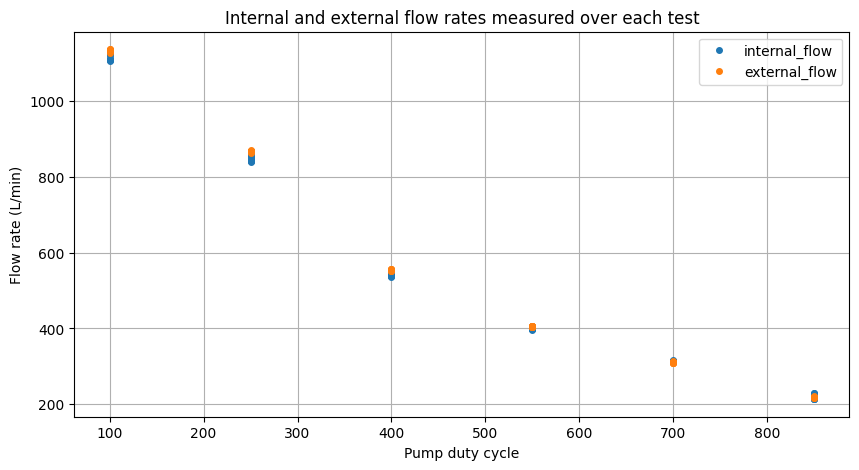

In [38]:
# plotting internal and external flow averages measured over each test
results_means.plot(x='set_pump_duty_cycle', y=['internal_flow', 'external_flow'], style='o', markersize=4, figsize=(10,5))
plt.xlabel('Pump duty cycle')
plt.ylabel('Flow rate (L/min)')
plt.title('Internal and external flow rates measured over each test')
plt.grid()
plt.show()

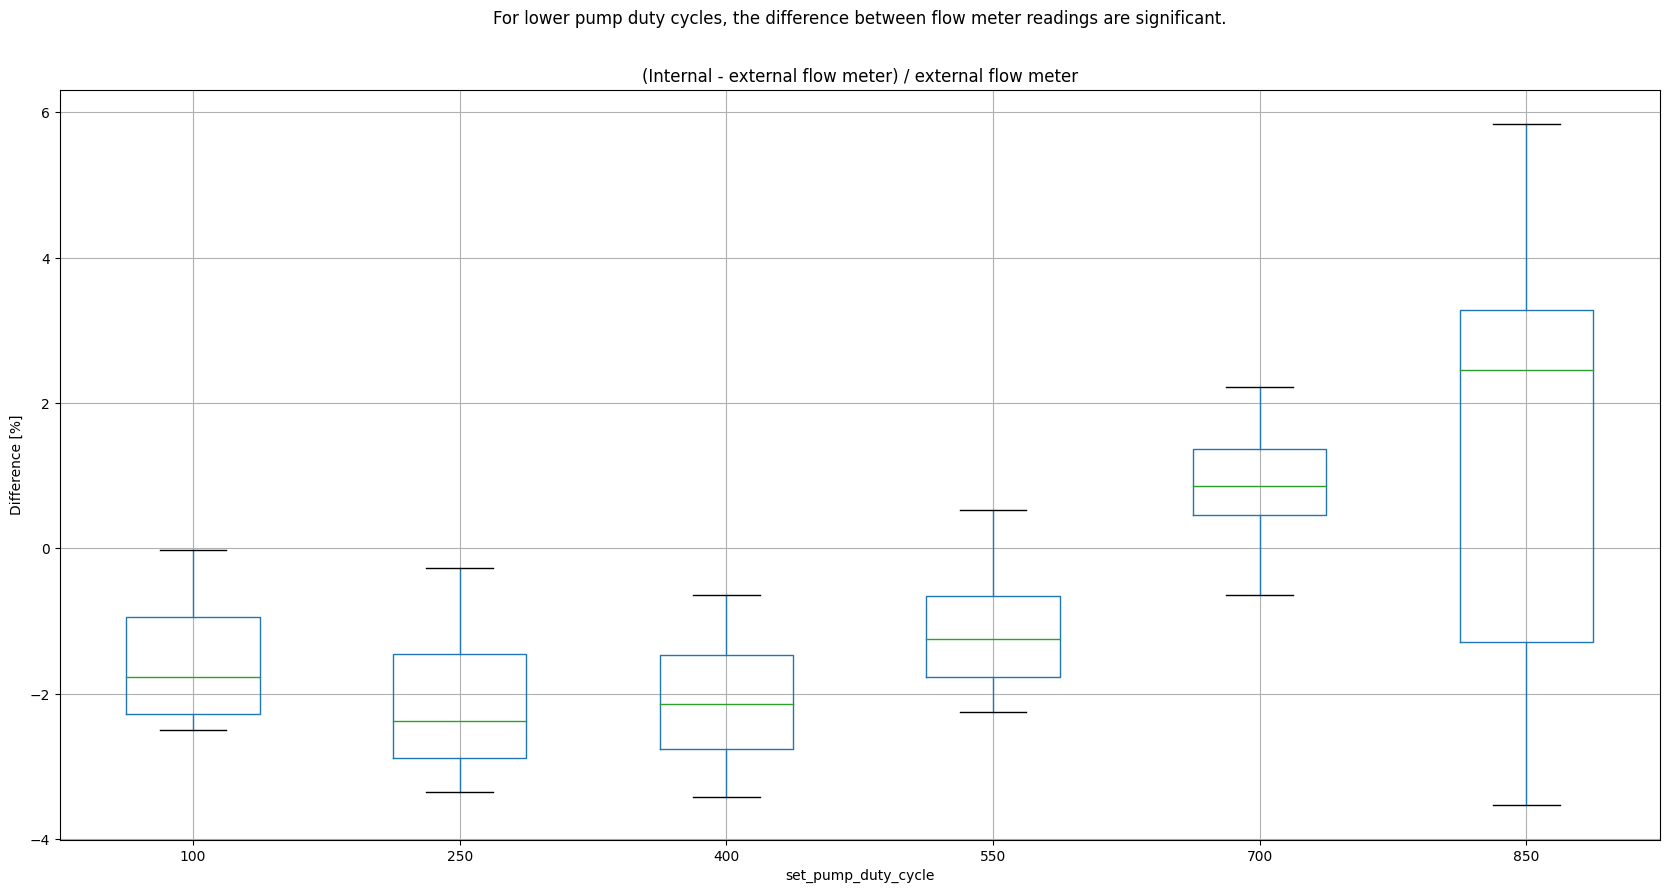

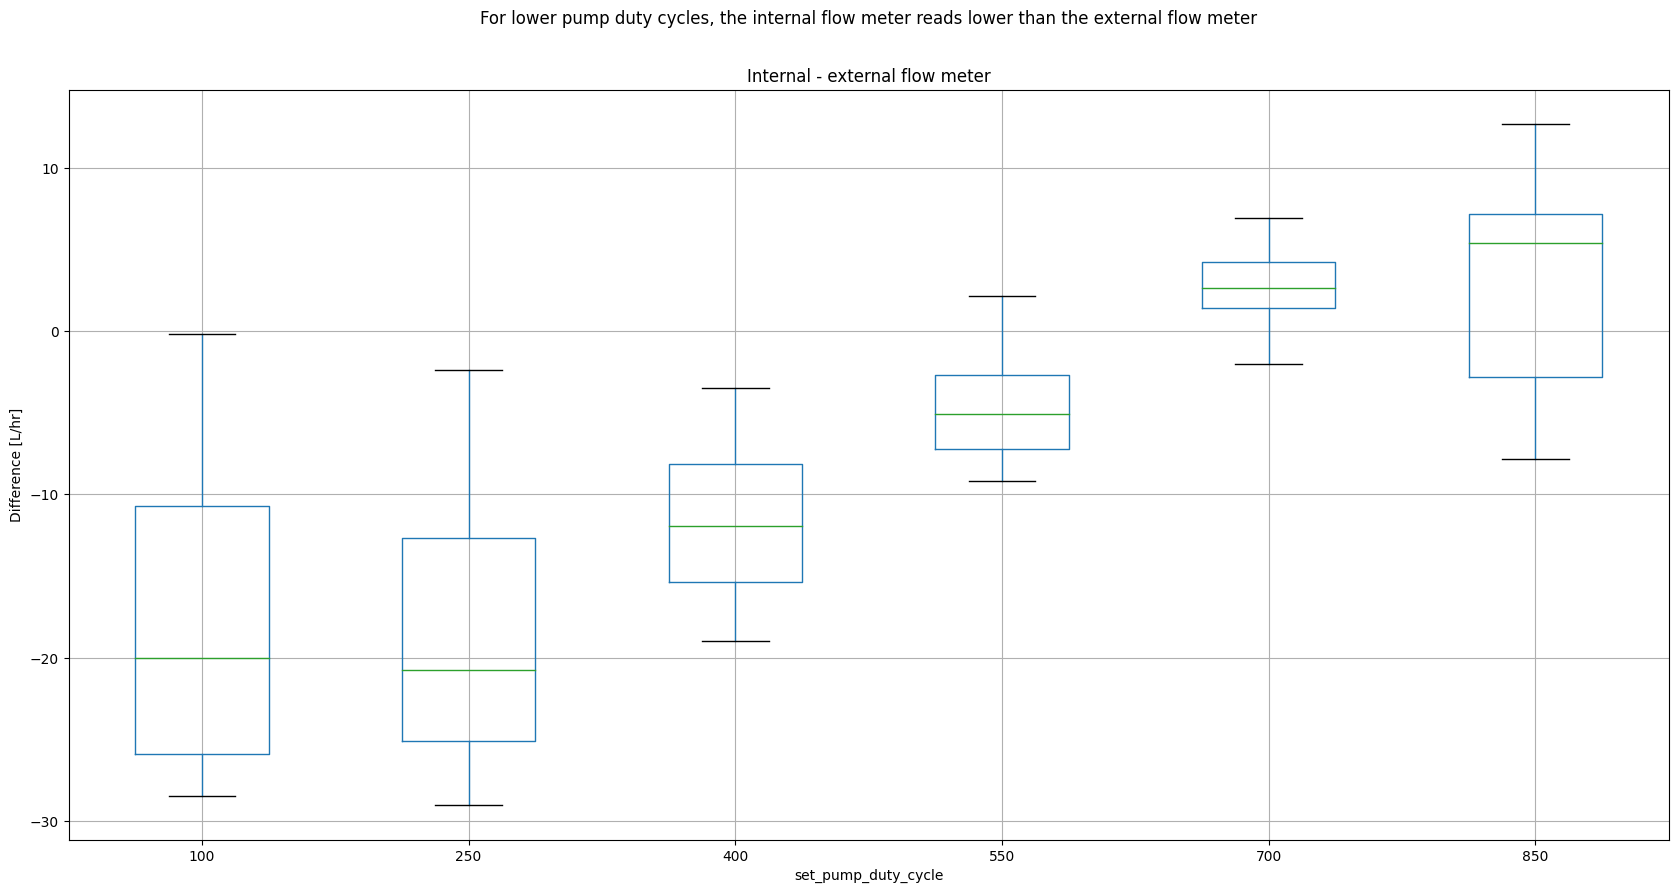

In [43]:

results_means['flow_difference'] = results_means['internal_flow'] - results_means['external_flow']
results_means['flow_difference_rel'] = results_means['flow_difference'] / results_means['external_flow'] *100

# boxplot of relative difference between internal and external flow meter
results_means.boxplot(by='set_pump_duty_cycle', column=['flow_difference_rel'], figsize=(20,10))
plt.title('(Internal - external flow meter) / external flow meter')
plt.suptitle('For lower pump duty cycles, the difference between flow meter readings are significant.')
plt.ylabel('Difference [%]')
plt.show()

# boxplot of absolute difference between internal and external flow meter
results_means.boxplot(by='set_pump_duty_cycle', column=['flow_difference'], figsize=(20,10))
plt.title('Internal - external flow meter')
plt.suptitle('For lower pump duty cycles, the internal flow meter reads lower than the external flow meter')
plt.ylabel('Difference [L/hr]')
plt.show()